# Predicting Customer Lifetime Value (CLV) using the BG/NBD and the Gamma-Gamma models.

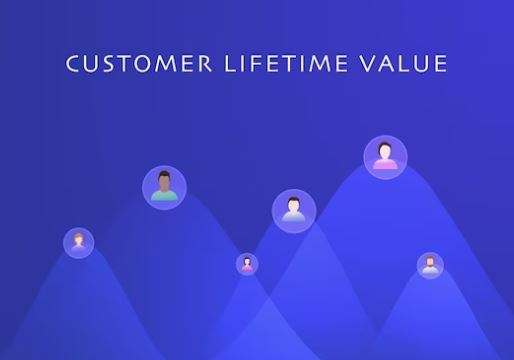

<font color='blue'>
A case study of predicting Customer Lifetime Value using the famous probabilistic models BG/NBD and Gamma-Gamma.

One of the major areas in **marketing** is the area of **Customer Lifetime Value (CLV)** modeling. Understanding and correctly calculating the CLV can help companies identify the most profitable customers, which in turn can facilitate the task of resource allocation when trying to retain customers. In this case high valuable customers deserve more attention and more resources than less valuable ones. CLV prediction can also help companies to budget and forecast future sales and revenue.

One of the most powerful tools for predicting customer lifetime value in non-contractual settings is the **BG/NBD model (combined with the Gamma-Gamma model)**, also known as the Beta-Geometric/Negative Binomial Distribution model.

The ***BG/NBD model*** is an integrated probabilistic model that describes two aspects of consumer behavior, the buying behavior and the churn behavior. This is done by using a combination of the following probability distributions:

* The Poisson distribution to model transactions and the exponential distribution to model the time between transactions.
* Because different consumers have different buying behaviors, The BG/NBD model uses the Gamma distribution to model the variation in the buying behavior across the population. Note that the combination of the Poisson/Gamma distributions is known as the negative binomial distribution (NBD) and this is where the name of the model comes from.
* After each purchase, a customer makes a decision whether to remain a customer or to churn. According to the creators of the model, this behavior can be modeled using the shifted geometric distribution.
* The Beta distribution is used to describe the variation in the churn probability across the population.
To calculate the CLV, we need to predict the expected value of purchases using the Gamma-Gamma model.

According to the creators of the model, the value of a given customer’s transaction follows a gamma distribution and the heterogeneity between customers follows similarly a gamma distribution. The use of the gamma distribution in both cases is the reason why the model is called ***Gamma-Gamma***.

The combination of the BG/NBD model and the Gamma-Gamma model can, not only, predict the CLV of each customer, but also has the ability to provide us with accurate answers to the following questions :

+ Which customers are still customers and which ones of them will order again in the next period.
+ The number of orders each customer will place and the average order value of each customer’s order.

## Table of Content

- [1 - Packages](#1)
- [2 - Reading Data](#2)
- [3 - Understanding Data](#3)
- [4 - Data Preprocessing](#4)
    - [4.1 - Rename Columns](#4.1)
    - [4.2 - Missing Values](#4.2)
    - [4.3 - Filtering Data](#4.3)
    - [4.4 - Changing Data types](#4.4)
    - [4.5 - Feature Engineering](#4.5)
    - [4.6 - Handling Outliers](#4.6)
    - [4.7 - Preparing RFM Dataset](#4.7)
        - [4.7.1 - Computing the summary data](#4.7.1)
        - [4.7.2 - Splitting the data](#4.7.2)
- [5 - BG/NBD model (Predict the Number Of Purchases)](#5)
    - [5.1 - Tuning the Hypreparameter](#5.1)
    - [5.2 - Fitting the BG/NBD model](#5.2)
- [6 - Gamma-Gamma Model (Predict Monetary and Customer Lifetime Value - CLV )](#6)
- [7 - Customer Segmentation using K-Means](#7)
- [8 - Conclusion](#8)
        
    

<a name='1'></a>
## 1 - Packages

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data,summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases,plot_frequency_recency_matrix,plot_probability_alive_matrix,plot_period_transactions,plot_history_alive
from decimal import Decimal 
import datetime as dt
import pyodbc

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})

<a name='2'></a>
## 1 - Reading Data

#### Instead of storing data in a csv file and call it, get data directly from SQL server

In [2]:
serverprop = ("Driver={SQL Server Native Client 11.0};"
            "Server=***;"
            "Database=***;"
            "UID=***;"
            "PWD=***;")
stp = pyodbc.connect(serverprop)

In [3]:
today=(dt.date.today()).strftime(format="%Y-%m-%d")
today

'2023-08-28'

In [4]:
query1=f" select markaz,Moshtary,DarkhastFaktor,TarikhForm,Kcode,Fee,( sum(SalesQty)- sum(ReturnQty)) as NetQty from \
    (SELECT sdf.ccMoshtary as Moshtary,sdf.ccDarkhastFaktor as DarkhastFaktor,wk.ccMarkazPakhsh as markaz,wk.TarikhForm as TarikhForm,wkala.CodeMother as Kcode,wks.Gheymat3 as Fee, sum(wks.Tedad3)as SalesQty, 0 as ReturnQty\
     FROM Warehouse.Kardex as wk left outer join Warehouse.KardexSatr as wks on wks.ccKardex=wk.ccKardex\
    left outer join Sales.darkhastfaktor as sdf on sdf.ccDarkhastFaktor=wk.ccRefrence\
    left outer join Warehouse.Kala as wkala on wkala.ccKalaCode=wks.ccKalaCode\
    where wk.CodeNoeForm=8 and wks.CodeNoeKala=1 and wk.CodeVazeiat=99\
    group by sdf.ccMoshtary,sdf.ccDarkhastFaktor,wk.TarikhForm,wkala.CodeMother,wks.Gheymat3,wk.ccMarkazPakhsh\
    Union All\
    SELECT sdf.ccMoshtary,sdf.ccDarkhastFaktor,NULL as markaz,wk.TarikhForm,wkala.CodeMother,wks.Gheymat3,0 as SalesQty,sum(wks.Tedad3)as ReturnQty\
    FROM Warehouse.Kardex as wk left outer join Warehouse.KardexSatr as wks on wks.ccKardex=wk.ccKardex\
    left outer join Sales.darkhastfaktor as sdf on sdf.ccDarkhastFaktor=wk.ccRefrence\
    left outer join Warehouse.Kala as wkala on wkala.ccKalaCode=wks.ccKalaCode\
    where wk.CodeNoeForm in (10,57) and wks.CodeNoeKala=1 and wk.CodeVazeiat=99\
    group by sdf.ccMoshtary,sdf.ccDarkhastFaktor,wk.TarikhForm,wkala.CodeMother,wks.Gheymat3) as kol\
    where TarikhForm between '2019-03-21' and '{today}'\
    group by markaz,Moshtary,DarkhastFaktor,TarikhForm,Kcode,Fee"

In [156]:
data = pd.read_sql( query1 , stp)

In [172]:
# Load the 'markaz.csv' file
markaz = pd.read_csv('markaz.csv')

# Merge 'data' and 'markaz' DataFrames on a common column
df = pd.merge(data, markaz, how='left')

<a name='3'></a>
# 3 - Understanding Data

In [173]:
df.sort_values('TarikhForm',ascending=False)

,markaz,Moshtary,DarkhastFaktor,TarikhForm,Kcode,Fee,NetQty,NameMarkazPakhsh
1041680,44.0,96428.0,1580822.0,2023-08-27 22:58:37.447,5236,496940.0,2.0,AHVAZ
2640323,44.0,96428.0,1580822.0,2023-08-27 22:58:37.447,5234,420490.0,2.0,AHVAZ
2718301,44.0,96428.0,1580822.0,2023-08-27 22:58:37.447,5424,284999.0,100.0,AHVAZ
3801229,44.0,96428.0,1580822.0,2023-08-27 22:58:37.447,5237,496940.0,3.0,AHVAZ
5569336,44.0,96428.0,1580822.0,2023-08-27 22:58:37.447,5232,420490.0,2.0,AHVAZ
...,...,...,...,...,...,...,...,...
1780451,12.0,84878.0,392319.0,2019-04-06 11:12:54.710,3016,77900.0,6.0,MASHHAD
1847117,12.0,84878.0,392319.0,2019-04-06 11:12:54.710,3114,139400.0,24.0,MASHHAD
4740706,12.0,84878.0,392319.0,2019-04-06 11:12:54.710,3015,86100.0,3.0,MASHHAD
2178189,12.0,86182.0,392308.0,2019-04-06 10:54:36.120,3029,123000.0,6.0,MASHHAD


In [174]:
#dataset size
df.shape

(5749569, 8)

In [175]:
# data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5749569 entries, 0 to 5749568
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   markaz            float64       
 1   Moshtary          float64       
 2   DarkhastFaktor    float64       
 3   TarikhForm        datetime64[ns]
 4   Kcode             object        
 5   Fee               float64       
 6   NetQty            float64       
 7   NameMarkazPakhsh  object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 394.8+ MB


In [176]:
df.columns

Index(['markaz', 'Moshtary', 'DarkhastFaktor', 'TarikhForm', 'Kcode', 'Fee',
       'NetQty', 'NameMarkazPakhsh'],
      dtype='object')

#### Features Descriptions

* markaz : BranchID
* Moshtary : CustomerID
* DarkhastFaktor : Invoice Number
* TarikhForm : Invoice Date
* Kcode : Product Code
* Fee : Unit Price
* NetQty : Sales Quantity
* NameMarkazPakhsh : Branch

In [177]:
#description of dataset
df.describe().style.bar()

,markaz,Moshtary,DarkhastFaktor,Fee,NetQty
count,5617129.000000,5747176.000000,5747176.000000,5749569.000000,5749569.000000
mean,30.280071,85800.411188,1009492.225118,322251.481726,17.990958
std,10.987727,4801.428097,350901.774439,534405.666960,71.631001
min,12.000000,78641.000000,392286.000000,1.000000,-10000.000000
25%,19.000000,81831.000000,695479.000000,144400.000000,3.000000
50%,32.000000,85160.000000,1036897.000000,237705.000000,6.000000
75%,36.000000,89362.000000,1330014.000000,373100.000000,12.000000
max,49.000000,97282.000000,1581163.000000,29969725.000000,19953.000000


In [178]:
#Number of unique values
df.nunique()

markaz                   15
Moshtary              15104
DarkhastFaktor       998533
TarikhForm          1061683
Kcode                  1404
Fee                    2301
NetQty                 1892
NameMarkazPakhsh         15
dtype: int64

In [179]:
# Verify the existence of duplicate values
df.duplicated().sum()

0

<a name='4'></a>
# 4 - Data Preprocessing

<a name='4.1'></a>
## 4.1 - Rename Columns

In [180]:
# Rename column names
df.columns=['BranchID','CustomerID', 'InvoiceNo', 'InvoiceDate', 'StockCode','UnitPrice','Quantity','Branch']

<a name='4.2'></a>
## 4.2 - Missing Values

In [181]:
# Verify the existence of NaN values
df.isna().sum()

BranchID       132440
CustomerID       2393
InvoiceNo        2393
InvoiceDate         0
StockCode           0
UnitPrice           0
Quantity            0
Branch         132440
dtype: int64

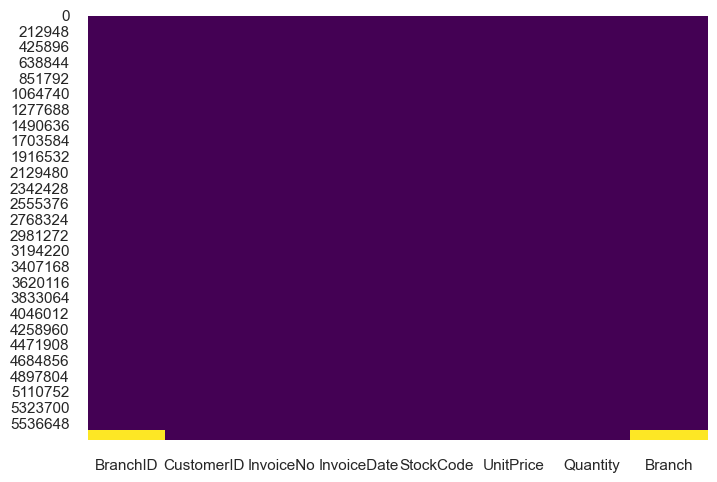

In [16]:
sns.heatmap(df.isnull(),cmap='viridis',cbar=False);

In [182]:
df.dropna(inplace=True)

<a name='4.3'></a>
## 4.3 - Filtering Data

In [183]:
# exclude the orders with 0 or negative value
df = df[df['Quantity'] > 0]

<a name='4.4'></a>
## 4.4 - Changing Data types

In [184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5617129 entries, 0 to 5617128
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   BranchID     float64       
 1   CustomerID   float64       
 2   InvoiceNo    float64       
 3   InvoiceDate  datetime64[ns]
 4   StockCode    object        
 5   UnitPrice    float64       
 6   Quantity     float64       
 7   Branch       object        
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 385.7+ MB


In [185]:
# Setting data types 
df['BranchID'] = df['BranchID'].astype('str')
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['StockCode'] = df['StockCode'].astype('str')
df['UnitPrice'] = df['UnitPrice'].apply(Decimal)
df['Quantity'] = df['Quantity'].apply(Decimal)
df['Branch'] = df['Branch'].astype('str')

In [186]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5617129 entries, 0 to 5617128
Data columns (total 8 columns):
 #   Column       Dtype         
---  ------       -----         
 0   BranchID     object        
 1   CustomerID   float64       
 2   InvoiceNo    object        
 3   InvoiceDate  datetime64[ns]
 4   StockCode    object        
 5   UnitPrice    object        
 6   Quantity     object        
 7   Branch       object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 385.7+ MB


<a name='4.5'></a>
## 4.5 - Feature Engineering

In [187]:
# Creating the monetary value of the transactions (quantity * price)
df['Monetary'] = df['Quantity'] * df['UnitPrice']
df['Monetary'] = df['Monetary'].apply(Decimal)
df['Monetary']

0           217300
1          4920000
2          1968000
3          2100000
4           655140
            ...   
5617124     615000
5617125    2568780
5617126    2296000
5617127     999000
5617128    9020000
Name: Monetary, Length: 5617129, dtype: object

<a name='4.6'></a>
## 4.6 - Handling Outliers

In [23]:
def find_boundaries(df, variable,q1=0.05,q2=0.95): # the boundaries are the quantiles
    lower_boundary = df[variable].quantile(q1) # lower quantile
    upper_boundary = df[variable].quantile(q2) # upper quantile
    return upper_boundary, lower_boundary
def capping_outliers(df,variable):
    upper_boundary,lower_boundary =  find_boundaries(df,variable)
    df[variable] = np.where(df[variable] > upper_boundary, upper_boundary,
                            np.where(df[variable] < lower_boundary, lower_boundary, df[variable]))

In [24]:
#capping_outliers(df,'Quantity')

<a name='4.7'></a>
## 4.7 - Preparing RFM Dataset

* R : Recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)
* F : Frequency represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
* M : Monetary Value represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.
* T : represents the age of the customer at whatever time units are chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.


<a name='4.7.1'></a>
## 4.7.1 - Computing the summary data

In [188]:
# Computing the summary data (Recency, Frequency, monetary and tenure)
df_rfmt = summary_data_from_transaction_data(transactions = df, 
                                         customer_id_col = 'CustomerID', 
                                         datetime_col = 'InvoiceDate', 
                                         monetary_value_col = 'Monetary')
df_rfmt.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
78641.0,1.0,29.0,1590.0,4.002139e+07
78642.0,43.0,1467.0,1477.0,4.227121e+07
78645.0,84.0,1539.0,1550.0,2.080060e+07
78646.0,28.0,1330.0,1580.0,1.049771e+07
78647.0,54.0,1490.0,1502.0,3.579548e+07


In [189]:
df_rfmt = df_rfmt[df_rfmt['frequency']>1] # we want only customers shopped more than 2 times

In [190]:
df_rfmt

,frequency,recency,T,monetary_value
CustomerID,,,,
78642.0,43.0,1467.0,1477.0,4.227121e+07
78645.0,84.0,1539.0,1550.0,2.080060e+07
78646.0,28.0,1330.0,1580.0,1.049771e+07
78647.0,54.0,1490.0,1502.0,3.579548e+07
78648.0,96.0,1566.0,1586.0,3.093738e+07
...,...,...,...,...
97218.0,2.0,10.0,14.0,1.104250e+07
97225.0,2.0,13.0,13.0,1.081261e+08
97226.0,2.0,12.0,12.0,2.819562e+07


<a name='4.7.2'></a>
## 4.7.2 - Splitting the data

In [191]:
# Size of the data 
diff_time = df['InvoiceDate'].max() - df['InvoiceDate'].min() 
total_days=diff_time.days
cal_days=int(total_days*0.9)

print(f"we have {total_days} days of data.")
print(f"We will use {cal_days} days as calibration data and the {total_days-cal_days} days as observation data to evaluate the performance of the model.")

we have 1604 days of data.
We will use 1443 days as calibration data and the 161 days as observation data to evaluate the performance of the model.


In [192]:
# Getting the ending date of the calibration period. 
end_date_cal = df['InvoiceDate'].min() + dt.timedelta(days=cal_days)
end_date_obs = end_date_cal + (diff_time - dt.timedelta(days=cal_days))
print('Start Day:' , df['InvoiceDate'].min())
print('End Day:' , df['InvoiceDate'].max())
print('Ending date of the calibration period:' , end_date_cal)
print('Ending date of the observation period:' , end_date_obs)

Start Day: 2019-04-06 10:54:36.120000
End Day: 2023-08-27 22:58:37.447000
Ending date of the calibration period: 2023-03-19 10:54:36.120000
Ending date of the observation period: 2023-08-27 22:58:37.447000


In [193]:
# Verify if the calculations are correct. 
df['InvoiceDate'].max() == end_date_obs

True

In [194]:
#Splitting dataset to calibration and holdout datasets
df_rfmt_cal = calibration_and_holdout_data(transactions=df, 
                                          customer_id_col="CustomerID",
                                          datetime_col = "InvoiceDate", 
                                          calibration_period_end=end_date_cal,
                                          observation_period_end= end_date_obs)
df_rfmt_cal

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
CustomerID,,,,,
78641.0,1.0,29.0,1429.0,0.0,161.0
78642.0,37.0,1225.0,1316.0,6.0,161.0
78645.0,82.0,1368.0,1389.0,2.0,161.0
78646.0,28.0,1330.0,1419.0,0.0,161.0
78647.0,45.0,1265.0,1341.0,9.0,161.0
...,...,...,...,...,...
96566.0,0.0,0.0,5.0,8.0,161.0
96567.0,1.0,1.0,5.0,0.0,161.0
96568.0,0.0,0.0,5.0,10.0,161.0


<a name='5'></a>
## 5 - BG/NBD model (Predict the Number Of Purchases)

<a name='5.1'></a>
### 5.1 - Tuning the Hyperparameter

***The BG/NBD model uses the L2 regularization. To find the best L2 coefficient we will use “Grid Search”.***

In [195]:
l2_coefs = [0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
l2_list = []
rmse_list = []
for coef in l2_coefs :
    # Fitting the model using the calibration dataset.
    model = BetaGeoFitter(penalizer_coef=coef)
    model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])
    # Predicting the frequency for the holdout period for all customers. 
    pred_freq = pd.DataFrame(model.predict(df_rfmt_cal['duration_holdout'], 
                                 df_rfmt_cal['frequency_cal'], df_rfmt_cal['recency_cal'], df_rfmt_cal['T_cal']), columns=['pred_frequency']).reset_index()
    # Merging the two dataframes and dropping NaN values. 
    new_df = df_rfmt_cal.reset_index().merge(pred_freq, on='CustomerID').dropna()

    # Computing the rmse score 
    rmse_score = np.sqrt(mean_squared_error(new_df['frequency_holdout'],new_df['pred_frequency']))
    l2_list.append(coef)
    rmse_list.append(rmse_score)

In [196]:
# Getting the results 
L2_=pd.DataFrame(np.array(rmse_list), columns=['rmse_score']).merge(pd.DataFrame(np.array(l2_list), columns=['L2 coefs']), right_index=True, left_index=True)
L2_.sort_values('rmse_score')

,rmse_score,L2 coefs
0,4.523708,0.1
1,4.541871,0.2
2,4.551885,0.3
3,4.559694,0.4
4,4.565286,0.5
5,4.569407,0.6
6,4.572919,0.7
7,4.575830,0.8
8,4.579069,0.9
9,4.582100,1.0


<a name='5.2'></a>
### 5.2 -  Fitting the BG/NBD model

In [197]:
# Fitting the model using the calibration dataset.
model = BetaGeoFitter(penalizer_coef=0.1)
model.fit(df_rfmt_cal['frequency_cal'], 
        df_rfmt_cal['recency_cal'], 
        df_rfmt_cal['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 14439 subjects, a: 0.03, alpha: 22.69, b: 0.51, r: 1.16>

In [198]:
#Summary of BG/NBD Model
model.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.163998,0.010616,1.143192,1.184805
alpha,22.694515,0.274810,22.155888,23.233142
a,0.031371,0.000775,0.029851,0.032890
b,0.507911,0.011906,0.484575,0.531247


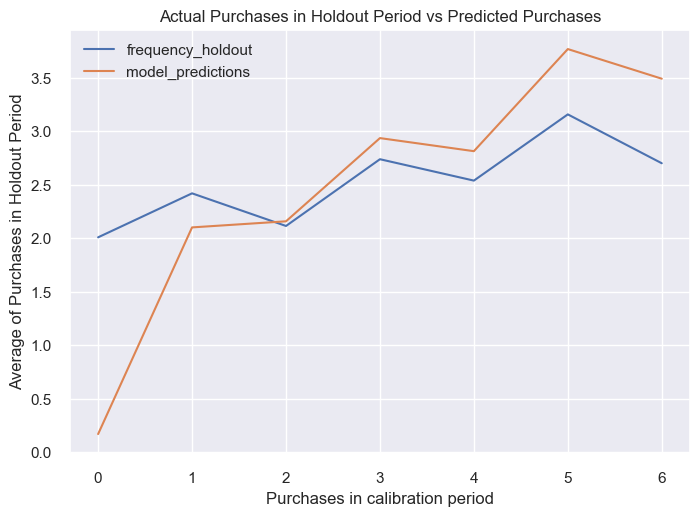

In [199]:
# Evaluating the performance of the model.
plot_calibration_purchases_vs_holdout_purchases(model, df_rfmt_cal)
plt.savefig('calib_hold.png')

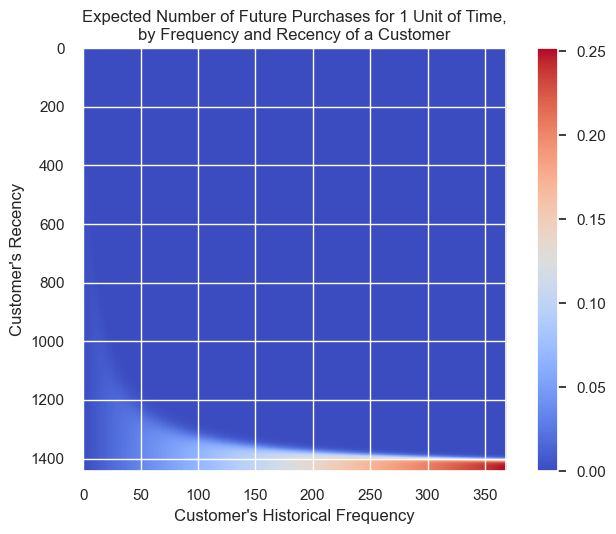

In [200]:
#Visualizing our Frequency/Recency Matrix
plot_frequency_recency_matrix(model)
plt.show();

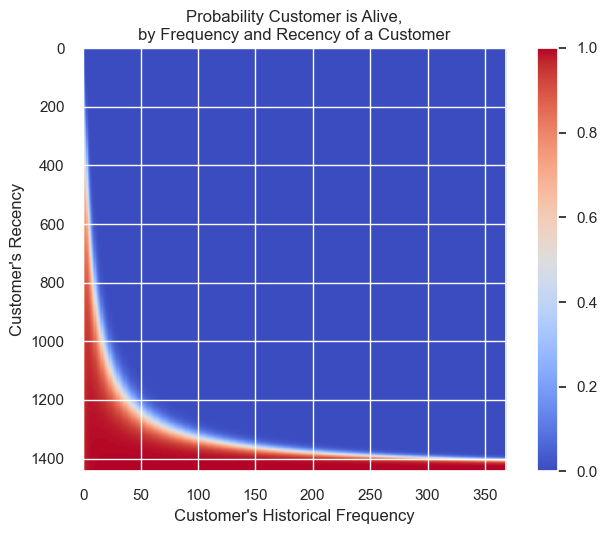

In [201]:
plot_probability_alive_matrix(model);

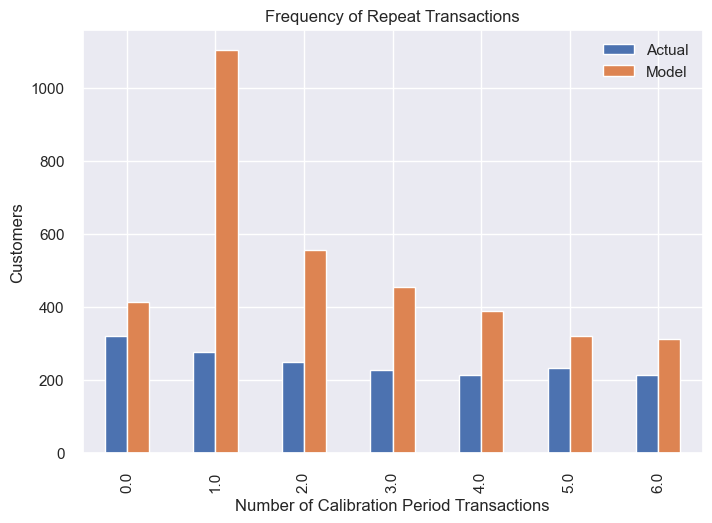

In [202]:
plot_period_transactions(model);

frequency                185
recency                1,492
T                      1,597
monetary_value    33,529,928
Name: 86408.0, dtype: object
Predicted Number Of Purchases for the next 6 months: 0.45288666399196353


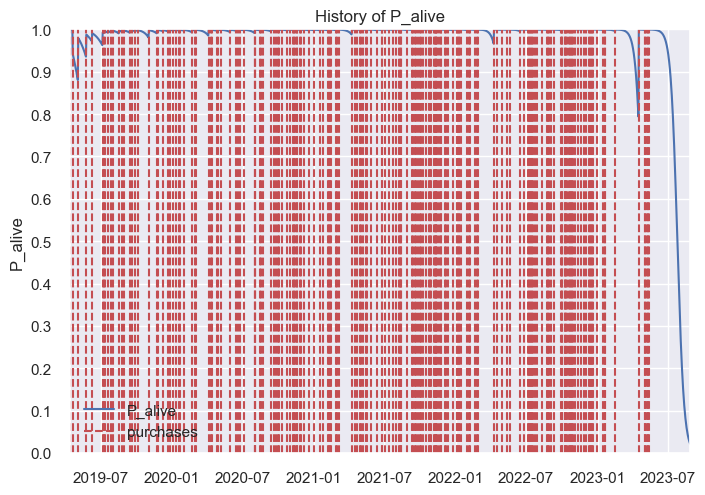

In [204]:
# Predicting the number of purchases in the next 180 days for the first customer.
id = 86408


# Getting the customer data
customer_1 = df_rfmt.loc[id,:]

# Function to format a number without scientific notation
def format_number(number):
    return "{:,.0f}".format(number)

# Formatting the values in the customer data Series
formatted_customer = customer_1.apply(format_number)

# Printing the formatted customer data
print(formatted_customer)

# Predict the number of purchases
predicted_purchases_customer_1= model.predict(180, 
                                    customer_1['frequency'], 
                                    customer_1['recency'], 
                                    customer_1['T'])

# Printing the predicted number of purchases
print("Predicted Number Of Purchases for the next 6 months:", predicted_purchases_customer_1)

days_since_birth = (df.InvoiceDate.max()-df[df['CustomerID'] == id].InvoiceDate.min()).days
sp_trans = df[df['CustomerID'] == id]
plot_history_alive(model, days_since_birth, sp_trans, 'InvoiceDate');

In [205]:
# Predicting the number of purchases in the next 180 days for all customers.
df_rfmt['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(180, 
                                                                                      df_rfmt['frequency'], 
                                                                                      df_rfmt['recency'], 
                                                                                      df_rfmt['T'])


In [206]:
df_rfmt.dropna(inplace=True)

In [207]:
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
78642.0,43.0,1467.0,1477.0,4.227121e+07,5.285583
78645.0,84.0,1539.0,1550.0,2.080060e+07,9.723496
78646.0,28.0,1330.0,1580.0,1.049771e+07,2.817785
78647.0,54.0,1490.0,1502.0,3.579548e+07,6.494647
78648.0,96.0,1566.0,1586.0,3.093738e+07,10.841179
...,...,...,...,...,...
97218.0,2.0,10.0,14.0,1.104250e+07,14.369029
97225.0,2.0,13.0,13.0,1.081261e+08,14.894646
97226.0,2.0,12.0,12.0,2.819562e+07,15.313707


<a name='6'></a>
## 6 - Gamma-Gamma Model (Predict Monetary and Customer Lifetime Value - CLV  )

**Assumptions for Gamma-Gamma Model***

In order to use the Gamma-Gamma model, we need to make sure that there is no correlation between frequency and monetary value.

In [208]:
df_rfmt[['frequency','monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,-0.115286
monetary_value,-0.115286,1.000000


In [209]:
# Getting rid of negative values.
df_rfmt = df_rfmt[df_rfmt['monetary_value']>0]

In [210]:
# Fitting the GammaGamma model 

gg_model = GammaGammaFitter(penalizer_coef=0.01)
gg_model.fit(df_rfmt['frequency'], df_rfmt['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 14520 subjects, p: 1.82, q: 0.07, v: 1.81>

In [211]:
df_rfmt['pred_monetary'] = gg_model.conditional_expected_average_profit(
        df_rfmt['frequency'],
        df_rfmt['monetary_value'])

In [212]:
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary
CustomerID,,,,,,
78642.0,43.0,1467.0,1477.0,4.227121e+07,5.285583,4.278154e+07
78645.0,84.0,1539.0,1550.0,2.080060e+07,9.723496,2.092840e+07
78646.0,28.0,1330.0,1580.0,1.049771e+07,2.817785,1.069361e+07
78647.0,54.0,1490.0,1502.0,3.579548e+07,6.494647,3.613876e+07
78648.0,96.0,1566.0,1586.0,3.093738e+07,10.841179,3.110357e+07
...,...,...,...,...,...,...
97218.0,2.0,10.0,14.0,1.104250e+07,14.369029,1.485142e+07
97225.0,2.0,13.0,13.0,1.081261e+08,14.894646,1.454223e+08
97226.0,2.0,12.0,12.0,2.819562e+07,15.313707,3.792122e+07


In [213]:
# Predicting the CLV.
df_rfmt['CLV'] = gg_model.customer_lifetime_value(
    model,
    df_rfmt['frequency'],
    df_rfmt['recency'],
    df_rfmt['T'],
    df_rfmt['monetary_value'],
    time = 6,# In months 
    )
    

In [214]:
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV
CustomerID,,,,,,,
78642.0,43.0,1467.0,1477.0,4.227121e+07,5.285583,4.278154e+07,2.184212e+08
78645.0,84.0,1539.0,1550.0,2.080060e+07,9.723496,2.092840e+07,1.965639e+08
78646.0,28.0,1330.0,1580.0,1.049771e+07,2.817785,1.069361e+07,2.910566e+07
78647.0,54.0,1490.0,1502.0,3.579548e+07,6.494647,3.613876e+07,2.267119e+08
78648.0,96.0,1566.0,1586.0,3.093738e+07,10.841179,3.110357e+07,3.257105e+08
...,...,...,...,...,...,...,...
97218.0,2.0,10.0,14.0,1.104250e+07,14.369029,1.485142e+07,2.061877e+08
97225.0,2.0,13.0,13.0,1.081261e+08,14.894646,1.454223e+08,2.092809e+09
97226.0,2.0,12.0,12.0,2.819562e+07,15.313707,3.792122e+07,5.610893e+08


In [215]:
# Computing the probability of being alive.
df_rfmt['prob_alive'] = model.conditional_probability_alive(frequency=df_rfmt['frequency'],
                                                           recency=df_rfmt['recency'],
                                                           T=df_rfmt['T'])

In [216]:
df_rfmt.sort_values('prob_alive')

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV,prob_alive
CustomerID,,,,,,,,
80027.0,64.0,367.0,1597.0,2.444530e+07,7.044725e-37,2.464281e+07,1.676869e-29,9.744620e-38
91520.0,117.0,575.0,1271.0,9.975535e+05,1.439634e-35,1.001946e+06,1.393295e-29,8.774949e-37
91433.0,111.0,553.0,1265.0,7.841105e+05,3.360464e-35,7.877507e+05,2.557023e-29,2.147876e-36
91354.0,114.0,592.0,1282.0,9.456211e+05,1.310321e-33,9.498951e+05,1.202264e-27,8.264346e-35
90007.0,71.0,467.0,1569.0,7.045194e+05,2.086656e-33,7.096463e+05,1.430335e-27,2.561394e-34
...,...,...,...,...,...,...,...,...
87370.0,268.0,1603.0,1603.0,4.316805e+07,2.974868e+01,4.325083e+07,1.242817e+09,9.998827e-01
79795.0,286.0,1600.0,1600.0,4.478203e+07,3.179692e+01,4.486249e+07,1.377886e+09,9.998901e-01
89335.0,287.0,1603.0,1603.0,3.556838e+07,3.184888e+01,3.563206e+07,1.096175e+09,9.998905e-01


<a name='7'></a>
## 7 - Customers segmentation using K-Means

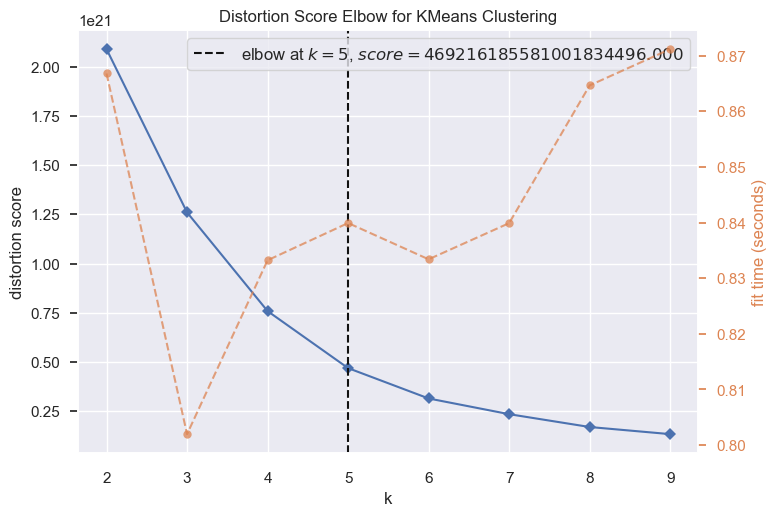

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [217]:
# Instantiate the clustering model and visualizer
km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k=(2,10))

visualizer.fit(pd.DataFrame(df_rfmt.CLV))  # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


In [218]:
# Training the model with the optimal number of clusters according the elbow method
km_model = KMeans(n_clusters=5)
km_model.fit(pd.DataFrame(df_rfmt.CLV))

KMeans(n_clusters=5)

In [219]:
df_rfmt['cluster'] = km_model.labels_
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV,prob_alive,cluster
CustomerID,,,,,,,,,
78642.0,43.0,1467.0,1477.0,4.227121e+07,5.285583,4.278154e+07,2.184212e+08,0.999009,0
78645.0,84.0,1539.0,1550.0,2.080060e+07,9.723496,2.092840e+07,1.965639e+08,0.999317,0
78646.0,28.0,1330.0,1580.0,1.049771e+07,2.817785,1.069361e+07,2.910566e+07,0.861821,0
78647.0,54.0,1490.0,1502.0,3.579548e+07,6.494647,3.613876e+07,2.267119e+08,0.999094,0
78648.0,96.0,1566.0,1586.0,3.093738e+07,10.841179,3.110357e+07,3.257105e+08,0.998894,0
...,...,...,...,...,...,...,...,...,...
97218.0,2.0,10.0,14.0,1.104250e+07,14.369029,1.485142e+07,2.061877e+08,0.970898,0
97225.0,2.0,13.0,13.0,1.081261e+08,14.894646,1.454223e+08,2.092809e+09,0.979620,4
97226.0,2.0,12.0,12.0,2.819562e+07,15.313707,3.792122e+07,5.610893e+08,0.979620,2


In [220]:
# Grouping by clusters
df_clusters = df_rfmt.groupby(['cluster'])['CLV']\
                     .agg(['mean', "count"])\
                     .reset_index()

df_clusters.columns = ["cluster", "avg_CLV", "n_customers"]

df_clusters['perct_customers'] = (df_clusters['n_customers']/df_clusters['n_customers']\
                                  .sum())*100
df_clusters.sort_values('avg_CLV',ascending=False)

,cluster,avg_CLV,n_customers,perct_customers
3,3,2.845849e+10,1,0.006887
1,1,6.130875e+09,27,0.185950
4,4,1.815160e+09,304,2.093664
2,2,5.936484e+08,2674,18.415978
0,0,1.229799e+08,11514,79.297521


In [221]:
# Let's name the clusters.
df_rfmt['customer_category'] = df_rfmt['cluster'].replace({3:"A", 1:"B", 4:"C", 2:"D", 0:"E"} )

<a name='8'></a>
## 8 - Conclusion

In [222]:
# Grouping by customer category
df_cat = pd.DataFrame(df_rfmt.groupby(['customer_category'])['CLV'].agg('mean')).reset_index()

In [223]:
def CLV_result_plotting(x, y, data, x_label, y_label, title):
    # Defining the plot size
    plt.figure(figsize=(8, 8))

    # Defining the values for x-axis, y-axis
    # and from which dataframe the values are to be picked
    plots = sns.barplot(x=x, y=y, data=data)

    # Iterating over the bars one-by-one
    for bar in plots.patches:
        # Using Matplotlib's annotate function and
        # passing the coordinates where the annotation shall be done
        # x-coordinate: bar.get_x() + bar.get_width() / 2
        # y-coordinate: bar.get_height()
        # free space to be left to make graph pleasing: (0, 8)
        # ha and va stand for the horizontal and vertical alignment
        plots.annotate(format(bar.get_height(), ',.0f'),
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=15, xytext=(0, 8), textcoords='offset points')

    plt.xlabel(x_label, size=14)
    plt.ylabel(y_label, size=14)
    plt.title(title)

    # Finally showing the plot
    plt.show()


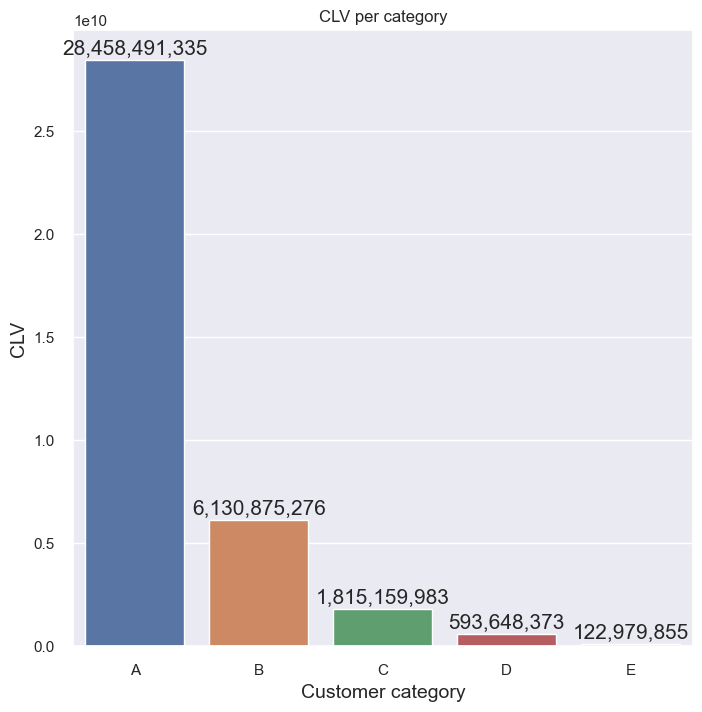

In [224]:
CLV_result_plotting(x="customer_category", y="CLV", data=df_cat, x_label="Customer category"
                    , y_label="CLV", title="CLV per category")

In [225]:
# Computing the contribution of each category to the total CLV of the next six months
df_cat["contribution_to_CLV"] = df_cat['CLV']/df_cat['CLV'].sum()*100

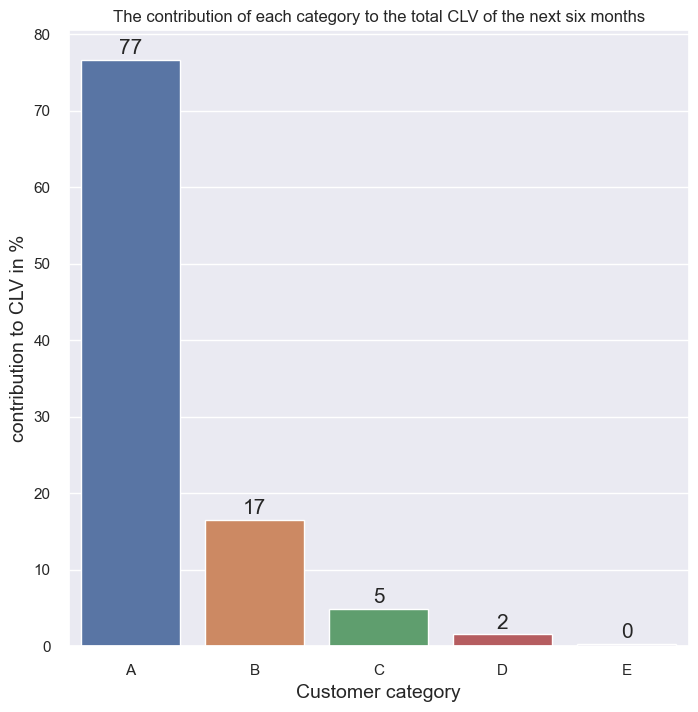

In [226]:
CLV_result_plotting(x="customer_category", y="contribution_to_CLV", data=df_cat, x_label="Customer category"
                    , y_label="contribution to CLV in %", title="The contribution of each category to the total CLV of the next six months")

## Analyzing the frequency

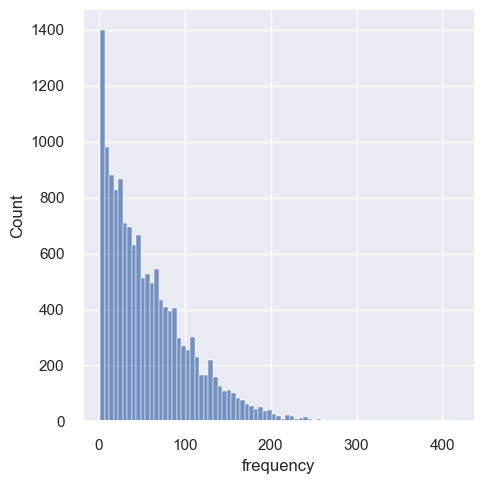

In [227]:
sns.displot(df_rfmt['frequency'])
plt.show()

In [228]:
df_freq = pd.DataFrame(df_rfmt.groupby(['customer_category'])['frequency'].mean().reset_index())

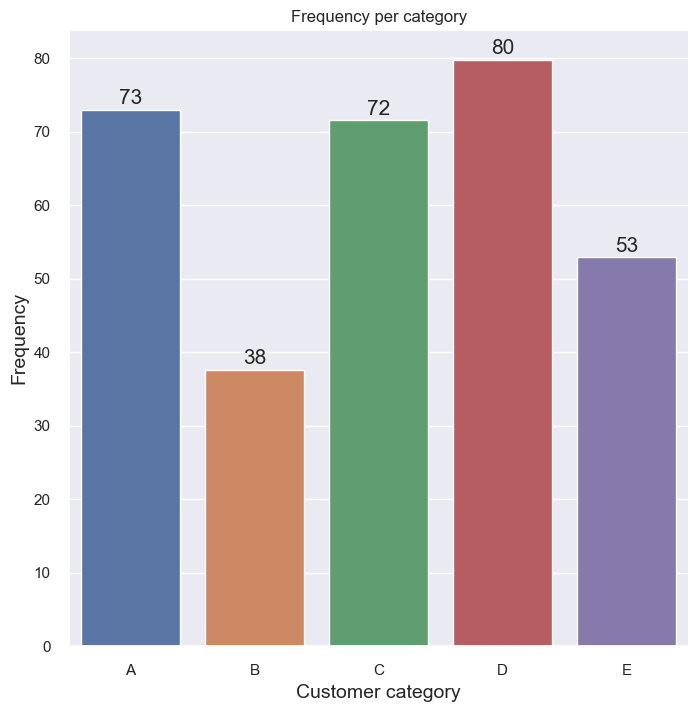

In [229]:
CLV_result_plotting(x="customer_category", y="frequency", data=df_freq, x_label="Customer category"
                    , y_label="Frequency", title="Frequency per category")

In [230]:
df_rfmt['frequency'].describe()

count    14520.000000
mean        58.246212
std         48.540917
min          2.000000
25%         20.000000
50%         46.000000
75%         84.000000
max        416.000000
Name: frequency, dtype: float64

In [231]:
# Getting the percentage of customers with a frequency less than 10.

len(df_rfmt[df_rfmt['frequency'] < 10])/len(df_rfmt)

0.12493112947658402

In [232]:
# Getting the number of customers per category for those with a frequency greater than 10.

df_freq_1 = pd.DataFrame(df_rfmt[df_rfmt['frequency'] > 10]\
                        .groupby(['customer_category'])['customer_category']\
                        .agg('count'))

df_freq_1.columns = ['n_customers']

df_freq_1 = df_freq_1.reset_index()

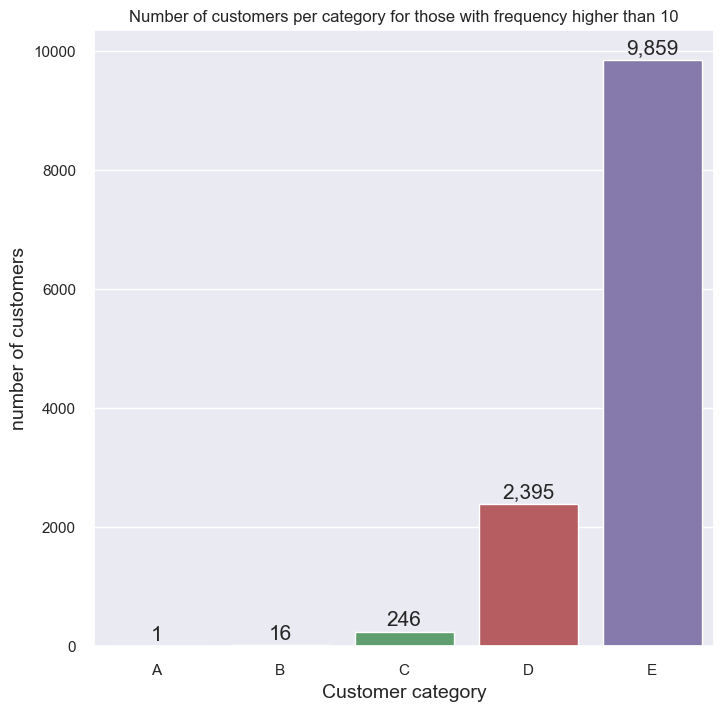

In [233]:
CLV_result_plotting(x="customer_category", y="n_customers", data=df_freq_1, x_label="Customer category"
                    , y_label="number of customers", title="Number of customers per category for those with frequency higher than 10")

In [234]:
# Getting the number of customers per category for those with a frequency less than 10.

df_freq_2 = pd.DataFrame(df_rfmt[df_rfmt['frequency'] < 10]\
                        .groupby(['customer_category'])['customer_category']\
                        .agg('count'))

df_freq_2.columns=['n_customers']

df_freq_2 = df_freq_2.reset_index()

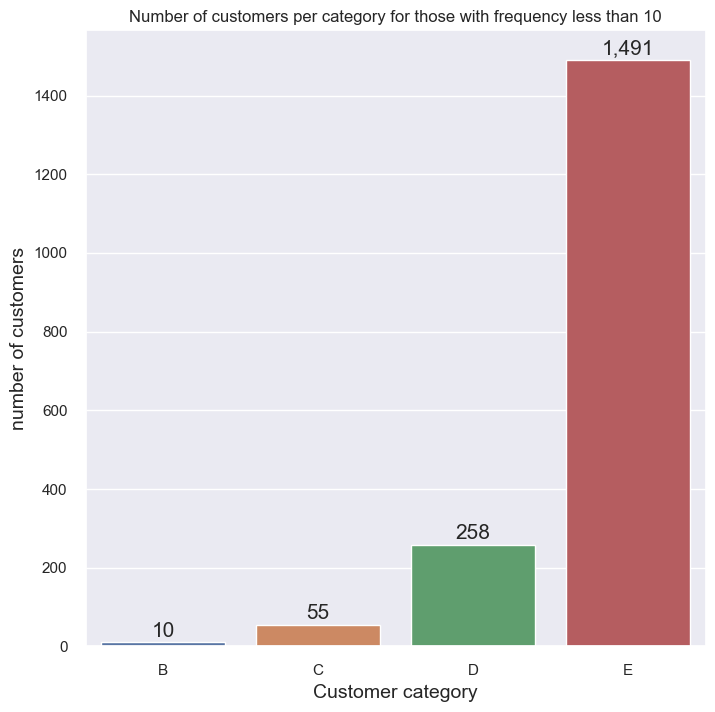

In [235]:
CLV_result_plotting(x="customer_category", y="n_customers", data=df_freq_2, x_label="Customer category"
                    , y_label="number of customers", title="Number of customers per category for those with frequency less than 10")

In [236]:
df_rfmt[df_rfmt['frequency'] > 10].reset_index().groupby(['customer_category'])['CustomerID'].agg('count')

customer_category
A       1
B      16
C     246
D    2395
E    9859
Name: CustomerID, dtype: int64

## Analyzing the monetary values

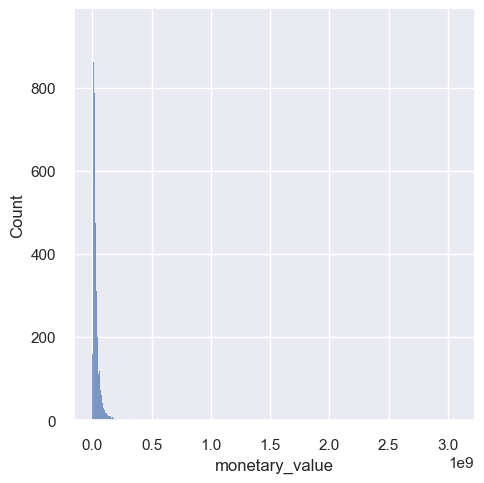

In [237]:
sns.displot(df_rfmt['monetary_value'])
plt.show()

In [238]:
df_rfmt['monetary_value'].describe()

count    1.452000e+04
mean     3.543611e+07
std      6.725588e+07
min      2.005273e+05
25%      1.318221e+07
50%      2.181852e+07
75%      3.835834e+07
max      3.067330e+09
Name: monetary_value, dtype: float64

In [239]:
df_mon = pd.DataFrame(df_rfmt.groupby(['customer_category'])['monetary_value'].mean().reset_index())

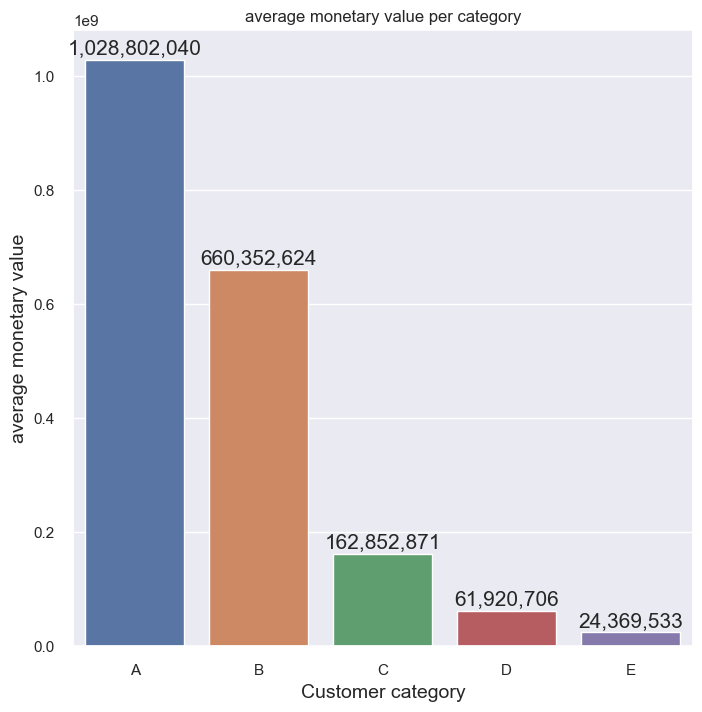

In [240]:
CLV_result_plotting(x="customer_category", y="monetary_value", data=df_mon, x_label="Customer category"
                    , y_label="average monetary value", title="average monetary value per category")

In [241]:
# Getting the 80th percentile 
perct = df_rfmt['monetary_value'].quantile(q=0.8)

In [242]:
# Getting the number of customers per category for those with a monetary value greater than the 80th percentile.

df_mon_1 = pd.DataFrame(df_rfmt[df_rfmt['monetary_value'] > perct]\
                        .groupby(['customer_category'])['customer_category']\
                        .agg('count'))

df_mon_1.columns = ['n_customers']

df_mon_1 = df_mon_1.reset_index()



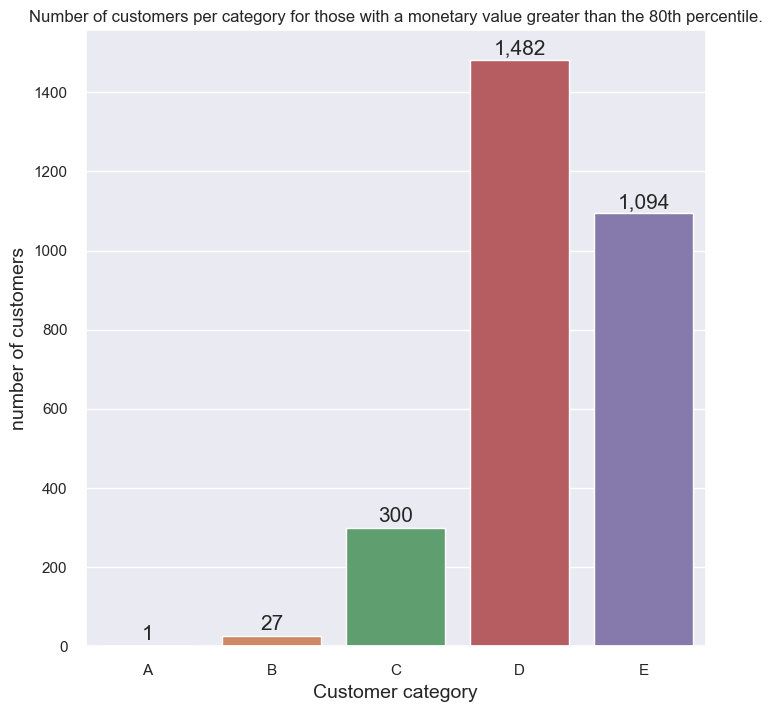

In [243]:
CLV_result_plotting(x="customer_category", y="n_customers", data=df_mon_1, x_label="Customer category"
                    , y_label="number of customers", title="Number of customers per category for those with a monetary value greater than the 80th percentile.")

In [244]:
# Getting the number of customers per category for those with a monetary value less than the 80th percentile.

df_mon_2= pd.DataFrame(df_rfmt[df_rfmt['monetary_value'] < perct]\
                        .groupby(['customer_category'])['customer_category']\
                        .agg('count'))

df_mon_2.columns = ['n_customers']

df_mon_2 = df_mon_2.reset_index()


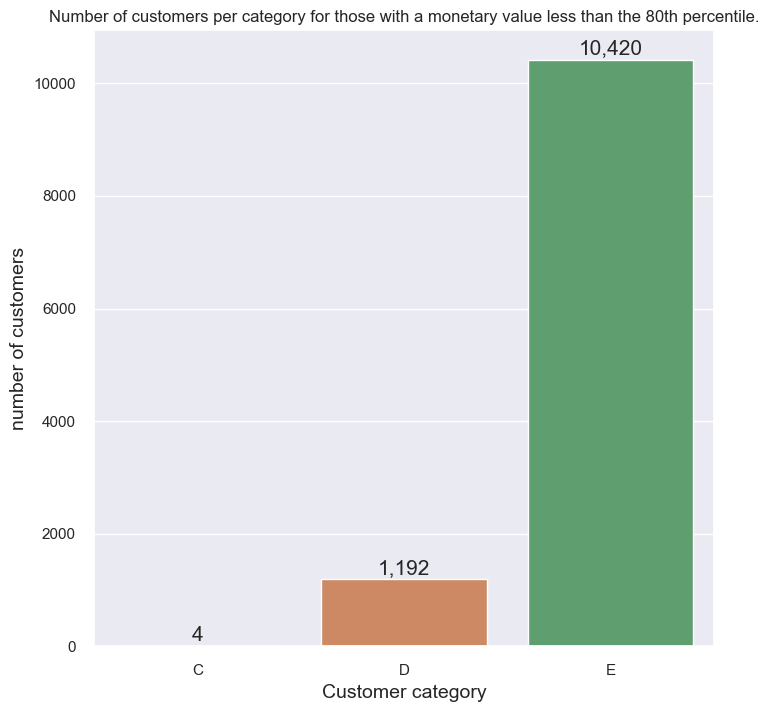

In [245]:
CLV_result_plotting(x="customer_category", y="n_customers", data=df_mon_2, x_label="Customer category"
                    , y_label="number of customers", title="Number of customers per category for those with a monetary value less than the 80th percentile.")

In [246]:
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases,pred_monetary,CLV,prob_alive,cluster,customer_category
CustomerID,,,,,,,,,,
78642.0,43.0,1467.0,1477.0,4.227121e+07,5.285583,4.278154e+07,2.184212e+08,0.999009,0,E
78645.0,84.0,1539.0,1550.0,2.080060e+07,9.723496,2.092840e+07,1.965639e+08,0.999317,0,E
78646.0,28.0,1330.0,1580.0,1.049771e+07,2.817785,1.069361e+07,2.910566e+07,0.861821,0,E
78647.0,54.0,1490.0,1502.0,3.579548e+07,6.494647,3.613876e+07,2.267119e+08,0.999094,0,E
78648.0,96.0,1566.0,1586.0,3.093738e+07,10.841179,3.110357e+07,3.257105e+08,0.998894,0,E
...,...,...,...,...,...,...,...,...,...,...
97218.0,2.0,10.0,14.0,1.104250e+07,14.369029,1.485142e+07,2.061877e+08,0.970898,0,E
97225.0,2.0,13.0,13.0,1.081261e+08,14.894646,1.454223e+08,2.092809e+09,0.979620,4,C
97226.0,2.0,12.0,12.0,2.819562e+07,15.313707,3.792122e+07,5.610893e+08,0.979620,2,D


In [ ]:
df_rfmt.to_csv('CLV.csv')